<a href="https://colab.research.google.com/github/limited-fion/deep-learning-cw/blob/master/07_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Functions

In [34]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from google.colab import drive
import os
drive.mount('/content/drive')

!wget https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf

font_files = fm.findSystemFonts()

# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)

# Use your new font on all your plots.
plt.rc('font', family='serif')

Mounted at /content/drive
--2023-03-14 18:32:35--  https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Times New Roman.ttf’

Times New Roman.ttf     [  <=>               ] 137.97K   643KB/s    in 0.2s    

2023-03-14 18:32:36 (643 KB/s) - ‘Times New Roman.ttf’ saved [141285]



In [1]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Layer, Input, Lambda 
from keras.layers import Multiply, Add, BatchNormalization, Reshape
from keras.layers import UpSampling2D, Convolution2D, LeakyReLU, Flatten, ReLU


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist
from keras import backend as K
from scipy.stats import norm

import matplotlib.image as mpimg
import sys

from tqdm import tqdm_notebook
from IPython import display
%matplotlib inline

from keras import initializers
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D

In [2]:
original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.   

11490434/11490434 [==============================] - 2s 0us/step


In [3]:
def nll(y_true, y_pred):
  """ Negative log likelihood (Bernoulli). """

  # keras.losses.binary_crossentropy gives the mean
  # over the last axis. we require the sum
  return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

class KLDivergenceLayer(Layer):

  """ Identity transform layer that adds KL divergence
  to the final model loss.
  """

  def __init__(self, *args, **kwargs):
    self.is_placeholder = True
    super(KLDivergenceLayer, self).__init__(*args, **kwargs)

  def call(self, inputs):
    mu, log_var = inputs
    kl_batch = - .5 * K.sum(1 + log_var -
                            K.square(mu) -
                            K.exp(log_var), axis=-1)
    self.add_loss(K.mean(kl_batch), inputs=inputs)

    return inputs

In [4]:
!wget https://imperialcollegelondon.box.com/shared/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5 -O inception_score_mnist.h5
inception_score_model = keras.models.load_model('./inception_score_mnist.h5')

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image
from keras.datasets import mnist
from PIL import Image as pil_image


def inception_score(x, resizer=None, batch_size=32, denorm_im=1):
    r = None
    n_batch = (x.shape[0]+batch_size-1) // batch_size
    for j in range(n_batch):
        x_batch = x[j*batch_size:(j+1)*batch_size, :, :, :]
        if denorm_im:
          x_batch = (x_batch + 1)/2
        r_batch = inception_score_model.predict(x_batch) # r has the probabilities for all classes
        r = r_batch if r is None else np.concatenate([r, r_batch], axis=0)
    p_y = np.mean(r, axis=0) # p(y)
    e = r*np.log(r/p_y) # p(y|x)log(P(y|x)/P(y))
    e = np.sum(e, axis=1) # KL(x) = Σ_y p(y|x)log(P(y|x)/P(y))
    e = np.mean(e, axis=0)
    return np.exp(e) # Inception score


def image_inception_score(generator, n_ex=10000, dim_random=10, input_noise=None, denorm_im=1):
    if input_noise is None:
      input_noise = np.random.normal(0,1,size=[n_ex,dim_random])
    x_pred = generator.predict(input_noise)
    if len(x_pred.shape)==2:
      x_pred = x_pred.reshape(n_ex, 28, 28, 1)
    return inception_score(x_pred, denorm_im=denorm_im)

--2023-03-14 17:43:56--  https://imperialcollegelondon.box.com/shared/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 74.112.186.144
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5 [following]
--2023-03-14 17:43:57--  https://imperialcollegelondon.box.com/public/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5 [following]
--2023-03-14 17:43:57--  https://imperialcollegelondon.app.box.com/public/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.box.com).

In [5]:
def plot_loss(losses):
    plt.figure()
    plt.plot(losses["d"], label='discriminitive loss')
    plt.plot(losses["g"], label='generative loss')
    plt.legend()
    plt.savefig('./loss.png')
    plt.close()
def plot_gen(mnist=1, n_ex=16, dim=(4,4), figsize=(10,10)):
    noise = np.random.normal(0,1,size=[n_ex,randomDim])
    generated_images = generator.predict(noise)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        if mnist:
          img = generated_images[i,:,:,0]
          plt.imshow(img, cmap='gray')
        else:
          img = generated_images[i,:,:,:]
          plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./images.png')
    plt.close()

def train_epoch(gan, generator, discriminator, plt_frq=25, BATCH_SIZE=32, mnist=1):  
  vector_ind = np.random.permutation(x_train.shape[0])
  nb_epoch = int(x_train.shape[0]/BATCH_SIZE)
  pbar = tqdm_notebook(range(nb_epoch))
  for e in range(nb_epoch):  
    ind = vector_ind[e*BATCH_SIZE:(e+1)*BATCH_SIZE]
    # Make generative images
    image_batch = x_train[ind,:,:,:]    
    noise_gen = np.random.normal(0,1,size=[BATCH_SIZE,randomDim])
    generated_images = generator.predict(noise_gen)
    # Train discriminator on generated images
    X = np.concatenate((image_batch, generated_images))
    y = np.zeros([2*BATCH_SIZE])
    y[0:BATCH_SIZE] = 1
    y[BATCH_SIZE:] = 0

    #make_trainable(discriminator,True)
    d_loss  = discriminator.train_on_batch(X,y)
    losses["d"].append(d_loss)
    # train Generator-Discriminator stack on input noise to non-generated output class
    noise_tr = np.random.normal(0,1,size=[BATCH_SIZE,randomDim])
    y2 = np.zeros([BATCH_SIZE])
    y2[:] = 1

    #make_trainable(discriminator,False)
    g_loss = gan.train_on_batch(noise_tr, y2 )
    losses["g"].append(g_loss)

    # Updates plots. This is a little bit of a mess due to how the notebook
    # handles the outputs
    if e % plt_frq==plt_frq-1:
      plot_loss(losses)
      plot_gen(mnist)
      fig, ax = plt.subplots(2,1, figsize=(20,10) )
      img=mpimg.imread('loss.png')
      ax[0].imshow(img)
      ax[0].axis('off')
      img=mpimg.imread('images.png')
      ax[1].imshow(img)
      ax[1].axis('off')
      plt.tight_layout()
      display.clear_output(wait=True)
      pbar.update(plt_frq)
      display.display(pbar)
      display.display(fig)
      plt.close()


# Task 1

### Latent dimension = 2

In [54]:
import tensorflow as tf
# TF 2.0 broke this code, so we have to add this line
tf.compat.v1.disable_eager_execution()

## Encoder
# LeakyReLU are used in GANs generator as are usually
# beneficial. We use it also in the VAE architecture 
# to match the GAN architecture, but ReLU works too.

latent_dim = 2
x = tf.keras.Input(shape=(original_dim,))
h = Reshape((28, 28, 1))(x)
h = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Flatten()(h)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = tf.keras.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

decoder = Sequential()
decoder.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
decoder.add(LeakyReLU(0.2))
decoder.add(Reshape((7, 7, 128)))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
decoder.add(LeakyReLU(0.2))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
decoder.add(Flatten())
x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 12s 198us/sample - loss: 173.4373 - val_loss: 161.7671
Epoch 2/20
60000/60000 [==============================] - 11s 178us/sample - loss: 159.8242 - val_loss: 158.1459
Epoch 3/20
60000/60000 [==============================] - 13s 210us/sample - loss: 157.2459 - val_loss: 156.1365
Epoch 4/20
60000/60000 [==============================] - 12s 199us/sample - loss: 155.8792 - val_loss: 154.3163
Epoch 5/20
60000/60000 [==============================] - 10s 163us/sample - loss: 154.7144 - val_loss: 154.1941
Epoch 6/20
60000/60000 [==============================] - 10s 172us/sample - loss: 154.0252 - val_loss: 154.0694
Epoch 7/20
60000/60000 [==============================] - 10s 169us/sample - loss: 153.2561 - val_loss: 152.7092
Epoch 8/20
60000/60000 [==============================] - 10s 167us/sample - loss: 152.8116 - val_loss: 152.7112
Epoch 9/20
60000/60000 [======================

The MSE is: 0.0417


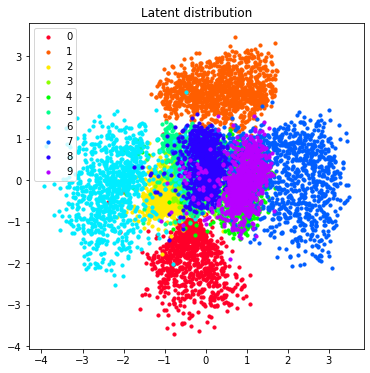

In [55]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_test, batch_size=batch_size)
images = decoder.predict(z_test)
print("The MSE is: {:.4f}".format(((images-x_test)**2).mean()))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6,6))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/(10)) for i in range(10)])
for l in range(10):
    # Only select indices for corresponding label
    ind = y_test == l
    ax.scatter(z_test[ind, 0], z_test[ind, 1], label=str(l),s=10)
ax.legend()
plt.title("Latent distribution")
plt.show()

In [57]:
image_inception_score(decoder, dim_random=2, denorm_im=0)

5.7242537

## Latent dimension = 4

In [58]:
import tensorflow as tf
# TF 2.0 broke this code, so we have to add this line
tf.compat.v1.disable_eager_execution()

original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.  

## Encoder
# LeakyReLU are used in GANs generator as are usually
# beneficial. We use it also in the VAE architecture 
# to match the GAN architecture, but ReLU works too.

latent_dim = 4
x = tf.keras.Input(shape=(original_dim,))
h = Reshape((28, 28, 1))(x)
h = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Flatten()(h)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = tf.keras.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

decoder = Sequential()
decoder.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
decoder.add(LeakyReLU(0.2))
decoder.add(Reshape((7, 7, 128)))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
decoder.add(LeakyReLU(0.2))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
decoder.add(Flatten())
x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 15s 242us/sample - loss: 149.5208 - val_loss: 136.2776
Epoch 2/20
60000/60000 [==============================] - 12s 201us/sample - loss: 134.9310 - val_loss: 134.9594
Epoch 3/20
60000/60000 [==============================] - 10s 166us/sample - loss: 132.9675 - val_loss: 133.1372
Epoch 4/20
60000/60000 [==============================] - 10s 172us/sample - loss: 131.7807 - val_loss: 132.4116
Epoch 5/20
60000/60000 [==============================] - 10s 165us/sample - loss: 130.9318 - val_loss: 131.2946
Epoch 6/20
60000/60000 [==============================] - 10s 161us/sample - loss: 130.2776 - val_loss: 130.5833
Epoch 7/20
60000/60000 [==============================] - 10s 166us/sample - loss: 129.7134 - val_loss: 130.2807
Epoch 8/20
60000/60000 [==============================] - 10s 171us/sample - loss: 129.2517 - val_loss: 129.8111
Epoch 9/20
60000/60000 [======================

The MSE is: 0.0284


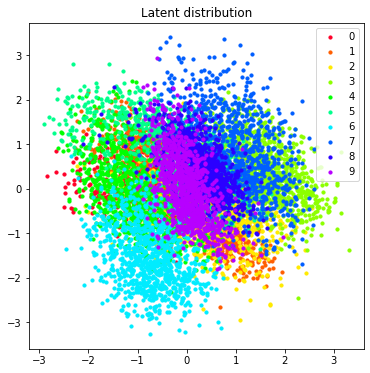

In [59]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_test, batch_size=batch_size)
images = decoder.predict(z_test)
print("The MSE is: {:.4f}".format(((images-x_test)**2).mean()))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6,6))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/(10)) for i in range(10)])
for l in range(10):
    # Only select indices for corresponding label
    ind = y_test == l
    ax.scatter(z_test[ind, 0], z_test[ind, 1], label=str(l),s=10)
ax.legend()
plt.title("Latent distribution")
plt.show()

In [60]:
image_inception_score(decoder, dim_random=4, denorm_im=0)

7.4154243

## 6


In [61]:
import tensorflow as tf
# TF 2.0 broke this code, so we have to add this line
tf.compat.v1.disable_eager_execution()

original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.  

## Encoder
# LeakyReLU are used in GANs generator as are usually
# beneficial. We use it also in the VAE architecture 
# to match the GAN architecture, but ReLU works too.

latent_dim = 6
x = tf.keras.Input(shape=(original_dim,))
h = Reshape((28, 28, 1))(x)
h = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Flatten()(h)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = tf.keras.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

decoder = Sequential()
decoder.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
decoder.add(LeakyReLU(0.2))
decoder.add(Reshape((7, 7, 128)))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
decoder.add(LeakyReLU(0.2))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
decoder.add(Flatten())
x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 12s 194us/sample - loss: 137.5589 - val_loss: 122.2261
Epoch 2/20
60000/60000 [==============================] - 10s 166us/sample - loss: 121.0929 - val_loss: 118.5522
Epoch 3/20
60000/60000 [==============================] - 10s 168us/sample - loss: 118.5246 - val_loss: 117.1297
Epoch 4/20
60000/60000 [==============================] - 10s 173us/sample - loss: 117.1589 - val_loss: 116.9493
Epoch 5/20
60000/60000 [==============================] - 10s 164us/sample - loss: 116.2397 - val_loss: 115.6206
Epoch 6/20
60000/60000 [==============================] - 10s 167us/sample - loss: 115.4526 - val_loss: 114.7340
Epoch 7/20
60000/60000 [==============================] - 10s 167us/sample - loss: 114.8234 - val_loss: 114.4273
Epoch 8/20
60000/60000 [==============================] - 10s 172us/sample - loss: 114.2778 - val_loss: 115.1697
Epoch 9/20
60000/60000 [======================

The MSE is: 0.0197


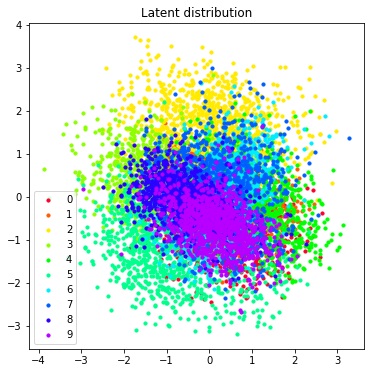

In [62]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_test, batch_size=batch_size)
images = decoder.predict(z_test)
print("The MSE is: {:.4f}".format(((images-x_test)**2).mean()))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6,6))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/(10)) for i in range(10)])
for l in range(10):
    # Only select indices for corresponding label
    ind = y_test == l
    ax.scatter(z_test[ind, 0], z_test[ind, 1], label=str(l),s=10)
ax.legend()
plt.title("Latent distribution")
plt.show()

In [63]:
image_inception_score(decoder, dim_random=6, denorm_im=0)

7.4690957

## 8

In [64]:
import tensorflow as tf
# TF 2.0 broke this code, so we have to add this line
tf.compat.v1.disable_eager_execution()

original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.  

## Encoder
# LeakyReLU are used in GANs generator as are usually
# beneficial. We use it also in the VAE architecture 
# to match the GAN architecture, but ReLU works too.

latent_dim = 8
x = tf.keras.Input(shape=(original_dim,))
h = Reshape((28, 28, 1))(x)
h = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Flatten()(h)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = tf.keras.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

decoder = Sequential()
decoder.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
decoder.add(LeakyReLU(0.2))
decoder.add(Reshape((7, 7, 128)))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
decoder.add(LeakyReLU(0.2))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
decoder.add(Flatten())
x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 12s 198us/sample - loss: 130.1456 - val_loss: 114.2171
Epoch 2/20
60000/60000 [==============================] - 10s 168us/sample - loss: 113.3020 - val_loss: 110.7651
Epoch 3/20
60000/60000 [==============================] - 11s 175us/sample - loss: 110.7941 - val_loss: 109.5215
Epoch 4/20
60000/60000 [==============================] - 10s 168us/sample - loss: 109.4886 - val_loss: 109.0877
Epoch 5/20
60000/60000 [==============================] - 10s 163us/sample - loss: 108.5622 - val_loss: 107.4959
Epoch 6/20
60000/60000 [==============================] - 10s 167us/sample - loss: 107.8481 - val_loss: 106.9461
Epoch 7/20
60000/60000 [==============================] - 10s 174us/sample - loss: 107.2910 - val_loss: 106.6790
Epoch 8/20
60000/60000 [==============================] - 10s 169us/sample - loss: 106.8285 - val_loss: 106.1997
Epoch 9/20
60000/60000 [======================

The MSE is: 0.0146


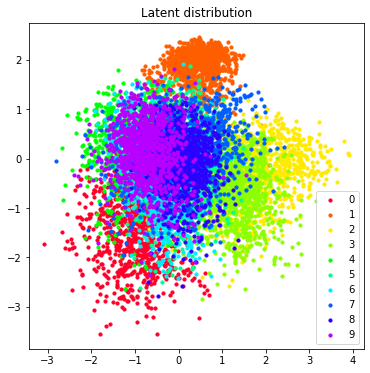

In [65]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_test, batch_size=batch_size)
images = decoder.predict(z_test)
print("The MSE is: {:.4f}".format(((images-x_test)**2).mean()))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6,6))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/(10)) for i in range(10)])
for l in range(10):
    # Only select indices for corresponding label
    ind = y_test == l
    ax.scatter(z_test[ind, 0], z_test[ind, 1], label=str(l),s=10)
ax.legend()
plt.title("Latent distribution")
plt.show()

In [66]:
image_inception_score(decoder, dim_random=8, denorm_im=0)

7.444928

## 10

In [40]:
import tensorflow as tf
# TF 2.0 broke this code, so we have to add this line
tf.compat.v1.disable_eager_execution()

## Encoder
# LeakyReLU are used in GANs generator as are usually
# beneficial. We use it also in the VAE architecture 
# to match the GAN architecture, but ReLU works too.

latent_dim = 10
x = tf.keras.Input(shape=(original_dim,))
h = Reshape((28, 28, 1))(x)
h = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Flatten()(h)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = tf.keras.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

decoder = Sequential()
decoder.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
decoder.add(LeakyReLU(0.2))
decoder.add(Reshape((7, 7, 128)))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
decoder.add(LeakyReLU(0.2))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
decoder.add(Flatten())
x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 11s 191us/sample - loss: 126.3441 - val_loss: 110.1940
Epoch 2/20
60000/60000 [==============================] - 11s 178us/sample - loss: 108.5453 - val_loss: 106.7025
Epoch 3/20
60000/60000 [==============================] - 10s 165us/sample - loss: 106.0918 - val_loss: 104.5127
Epoch 4/20
60000/60000 [==============================] - 10s 165us/sample - loss: 104.7584 - val_loss: 103.5894
Epoch 5/20
60000/60000 [==============================] - 10s 166us/sample - loss: 103.8440 - val_loss: 103.3406
Epoch 6/20
60000/60000 [==============================] - 10s 167us/sample - loss: 103.1646 - val_loss: 103.3141
Epoch 7/20
60000/60000 [==============================] - 10s 169us/sample - loss: 102.6822 - val_loss: 102.5798
Epoch 8/20
60000/60000 [==============================] - 10s 161us/sample - loss: 102.2816 - val_loss: 102.0962
Epoch 9/20
60000/60000 [======================

The MSE is: 0.0119


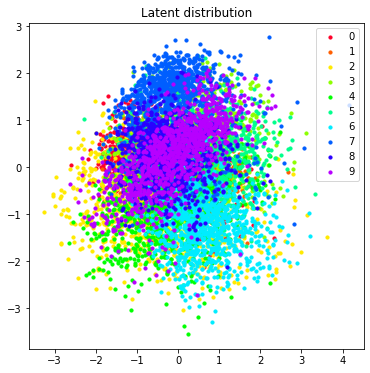

In [41]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_test, batch_size=batch_size)
images = decoder.predict(z_test)
print("The MSE is: {:.4f}".format(((images-x_test)**2).mean()))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6,6))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/(10)) for i in range(10)])
for l in range(10):
    # Only select indices for corresponding label
    ind = y_test == l
    ax.scatter(z_test[ind, 0], z_test[ind, 1], label=str(l),s=10)
ax.legend()
plt.title("Latent distribution")
plt.show()

In [42]:
image_inception_score(decoder, dim_random=10, denorm_im=0)

7.3778315

## without KL divergence loss


In [15]:
import tensorflow as tf
# TF 2.0 broke this code, so we have to add this line
tf.compat.v1.disable_eager_execution()

original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.  

## Encoder
# LeakyReLU are used in GANs generator as are usually
# beneficial. We use it also in the VAE architecture 
# to match the GAN architecture, but ReLU works too.

latent_dim = 10
x = tf.keras.Input(shape=(original_dim,))
h = Reshape((28, 28, 1))(x)
h = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Flatten()(h)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
# z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = tf.keras.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

decoder = Sequential()
decoder.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
decoder.add(LeakyReLU(0.2))
decoder.add(Reshape((7, 7, 128)))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
decoder.add(LeakyReLU(0.2))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
decoder.add(Flatten())
x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 163us/sample - loss: 102.0812 - val_loss: 84.1215
Epoch 2/20
60000/60000 [==============================] - 9s 156us/sample - loss: 82.6638 - val_loss: 80.7119
Epoch 3/20
60000/60000 [==============================] - 9s 153us/sample - loss: 79.8270 - val_loss: 78.8159
Epoch 4/20
60000/60000 [==============================] - 9s 153us/sample - loss: 78.2526 - val_loss: 77.9219
Epoch 5/20
60000/60000 [==============================] - 9s 153us/sample - loss: 77.1828 - val_loss: 76.6210
Epoch 6/20
60000/60000 [==============================] - 9s 153us/sample - loss: 76.4373 - val_loss: 76.4586
Epoch 7/20
60000/60000 [==============================] - 9s 149us/sample - loss: 75.8349 - val_loss: 75.8441
Epoch 8/20
60000/60000 [==============================] - 9s 156us/sample - loss: 75.3850 - val_loss: 75.4417
Epoch 9/20
60000/60000 [==============================] - 9s 154us/s

The MSE is: 0.0107


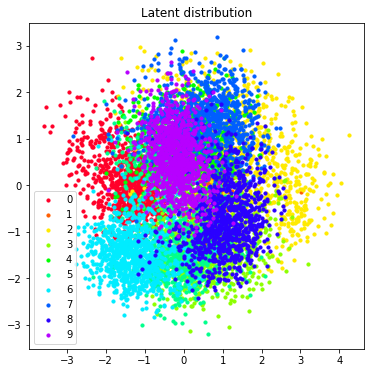

In [16]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_test, batch_size=batch_size)
images = decoder.predict(z_test)
print("The MSE is: {:.4f}".format(((images-x_test)**2).mean()))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6,6))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/(10)) for i in range(10)])
for l in range(10):
    # Only select indices for corresponding label
    ind = y_test == l
    ax.scatter(z_test[ind, 0], z_test[ind, 1], label=str(l),s=10)
ax.legend()
plt.title("Latent distribution")
plt.show()

In [17]:
image_inception_score(decoder, dim_random=10, denorm_im=0)

ValueError: ignored

## GAN

In [45]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 5
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 6272)              37632     
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_22 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_22 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 14, 14, 64)        204864    
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                     

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_22 (Flatten)        (None, 6272)            

In [46]:
# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 5)]               0         
                                                                 
 sequential_11 (Sequential)  (None, 28, 28, 1)         244097    
                                                                 
 sequential_12 (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 456,962
Trainable params: 244,097
Non-trainable params: 212,865
_________________________________________________________________


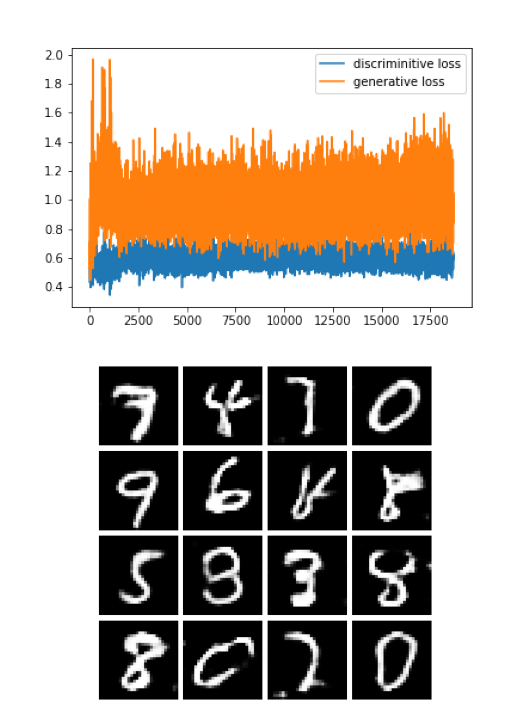

In [47]:
# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

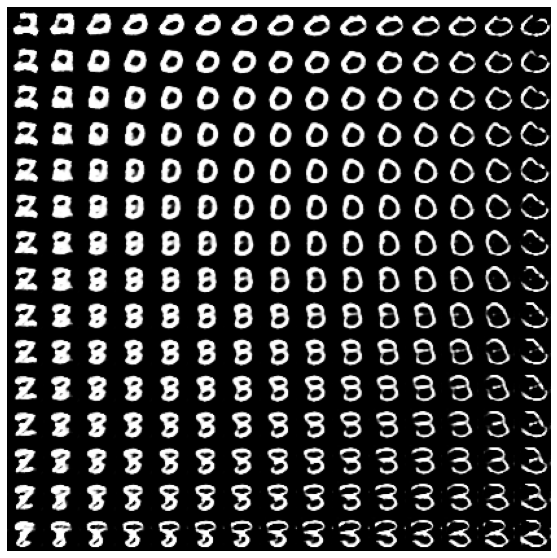

In [48]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [50]:
image_inception_score(generator, dim_random=5, denorm_im=1)

8.21912

## 6

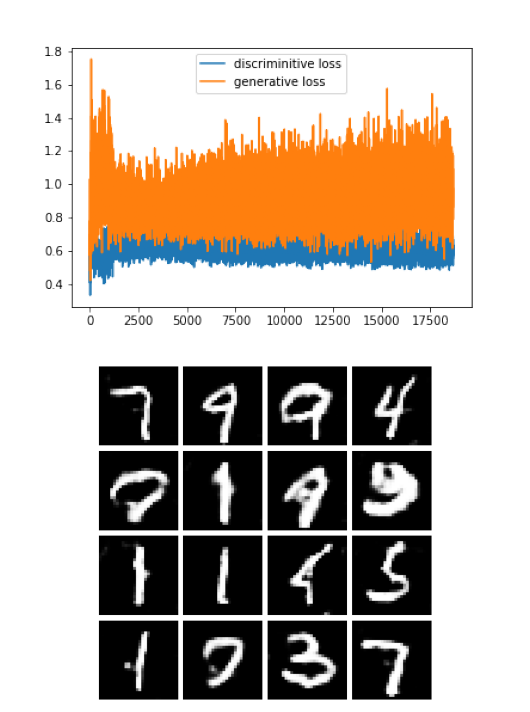

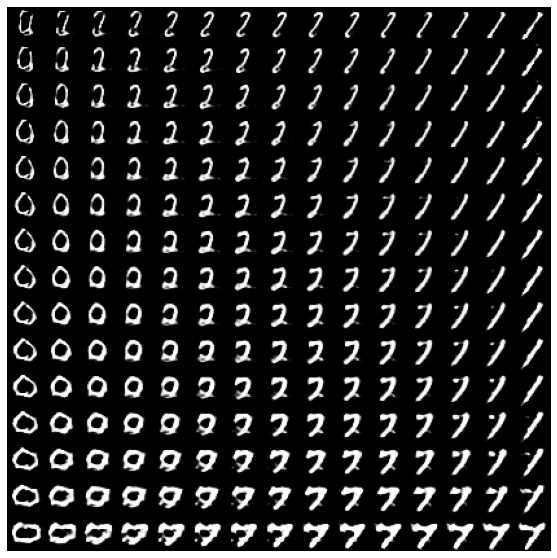

In [72]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 6
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [73]:
image_inception_score(generator, dim_random=6, denorm_im=1)

8.106026

## 7

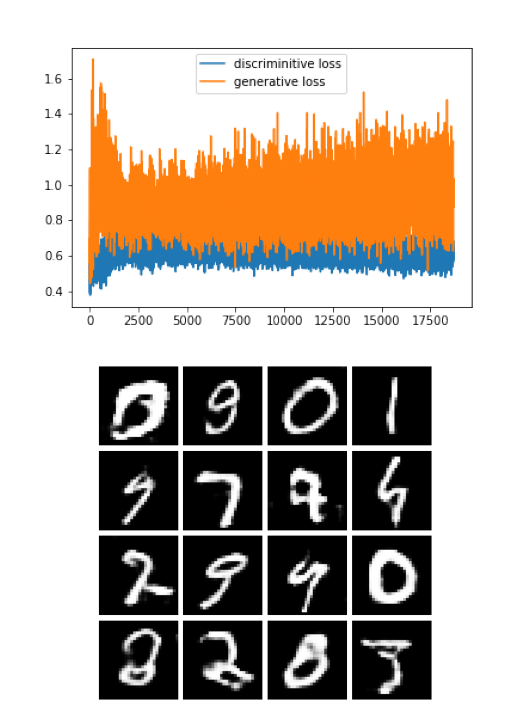

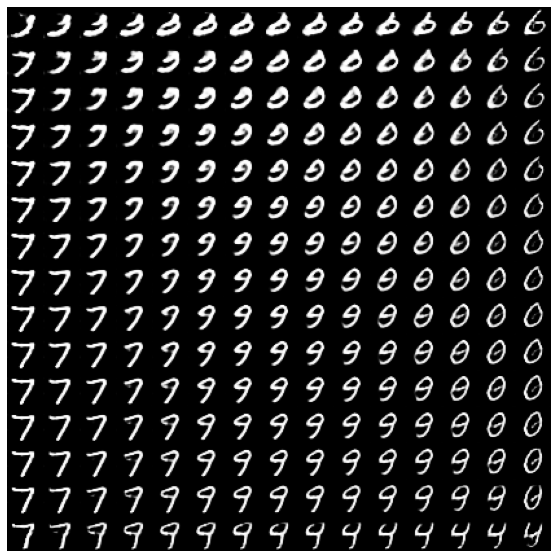

In [74]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 7
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [75]:
image_inception_score(generator, dim_random=7, denorm_im=1)


8.132663

## 8

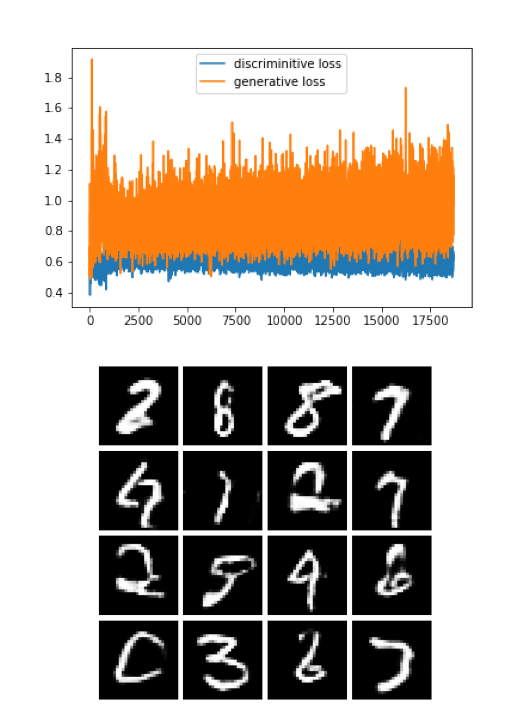

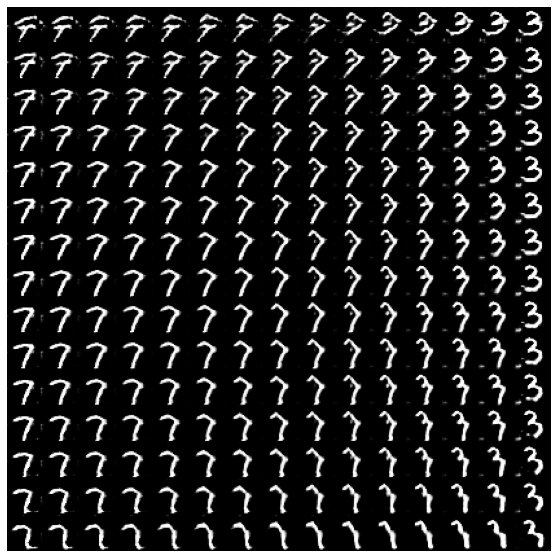

In [76]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 8
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [77]:
image_inception_score(generator, dim_random=8, denorm_im=1)

8.273274

## 9

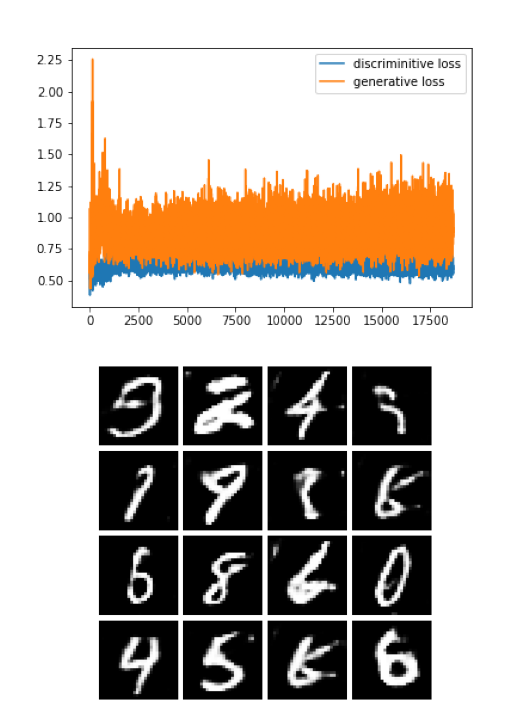

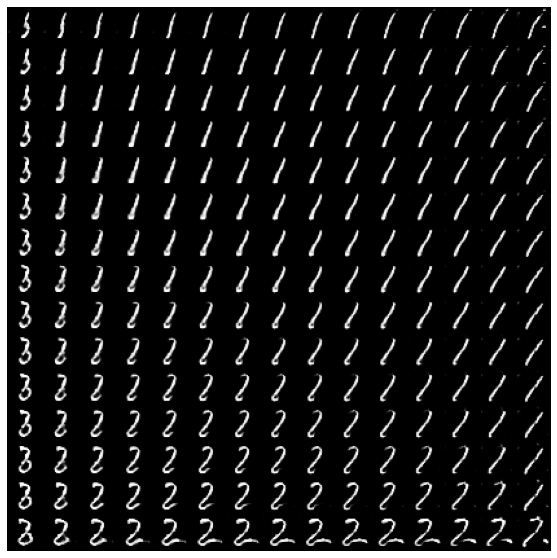

In [78]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 9
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [79]:
image_inception_score(generator, dim_random=9, denorm_im=1)


8.300297

## 10

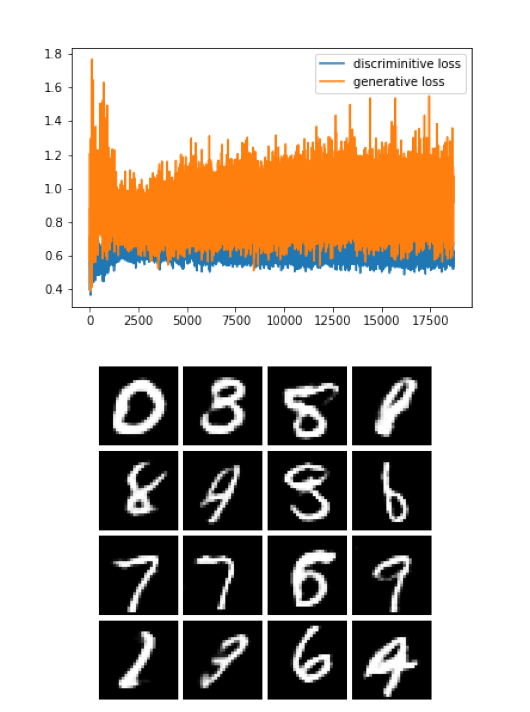

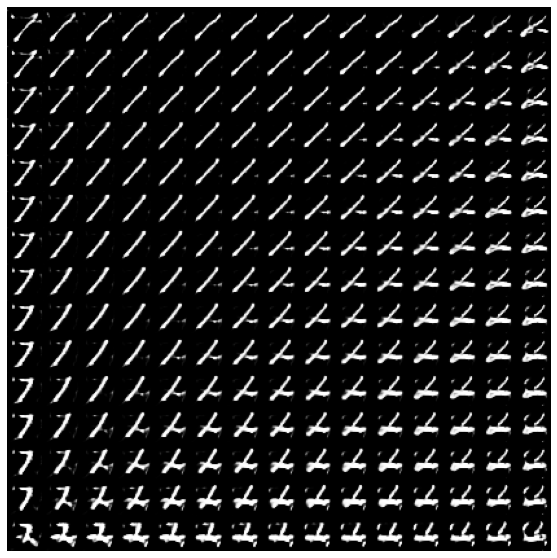

In [83]:
original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.  

# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 10
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [84]:
image_inception_score(generator, dim_random=10, denorm_im=1)


8.202063

# Task 2

## CGAN

In [20]:
import keras
from keras.datasets import cifar10, cifar100
from keras.layers import Lambda, Input
from keras.models import Model
import tensorflow as ktf
import numpy as np
import matplotlib.pyplot as plt
import datetime

class DataLoader():
  def __init__(self, dataset_name, img_res=(32, 32)):
    self.dataset_name = dataset_name
    self.img_res = img_res
    self.load_dataset()
  
  def _start_epoch(self):  
  
    random_idx = np.random.permutation(len(self.im_A_train))
    self.im_A_train_epoch = self.im_A_train[random_idx]
    
  def load_dataset(self):
    
    if self.dataset_name == 'CIFAR10':
      (im_A_train, y_train), (im_A_test, y_test) = cifar10.load_data()
    elif self.dataset_name == 'CIFAR100':
      (im_A_train, y_train), (im_A_test, y_test) = cifar100.load_data()
    else:
      raise Exception('Please, select a valid dataset')
      
    self.im_A_train = im_A_train.astype('float32')
    self.im_A_test = im_A_test.astype('float32')
    self.im_A_train /= 255.
    self.im_A_test /= 255.
    
  def get_dataset_shape(self, is_training=True):
    
    if is_training:
      return self.im_A_train.shape
    else:
      return self.im_A_test.shape
    
  def get_num_batches(self, batch_size):
    return int(self.im_A_train.shape[0] / batch_size)
  
  def set_image_transformations(self, convert_to_bw):
    
    self.convert_to_bw = convert_to_bw
  
  def load_batch(self, batch_size=1, is_training=True):
        
    if is_training:
      
      self._start_epoch()   
      num_batches = int((self.im_A_train).shape[0] / batch_size)
      
    else:
      num_batches = int((self.im_A_test).shape[0] / batch_size)
    
    for idx_batch in range(num_batches):
      
      init = idx_batch * batch_size
      end = (idx_batch + 1) * batch_size
      
      if is_training:
        batch = self.im_A_train_epoch[init:end]
      else:
        batch = self.im_A_test[init:end]
 
      batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))
            
      # Convert to B&W
      batch_bw = self.convert_to_bw.predict(batch)
      
      yield [batch, batch_bw]

  def get_random_batch(self, batch_size=1, is_training=True):
    
    if is_training:
      random_idx = np.random.permutation(len(self.im_A_train))
      batch = self.im_A_train[random_idx[0:batch_size]]
    else:
      random_idx = np.random.permutation(len(self.im_A_test))
      batch = self.im_A_test[random_idx[0:batch_size]]

    batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))
        
    # Convert to B&W
    batch_bw = self.convert_to_bw.predict(batch)
      
    return [batch, batch_bw]

In [21]:
# Load the data, shuffled and split between train and test sets
dataset_loader = DataLoader(dataset_name = 'CIFAR10')

training_shape = dataset_loader.get_dataset_shape()
test_shape = dataset_loader.get_dataset_shape(is_training=False)

print('Shape of Training Images: {}'.format(training_shape))
print('Shape of Test Images: {}'.format(test_shape))

170498071/170498071 [==============================] - 14s 0us/step
Shape of Training Images: (50000, 32, 32, 3)
Shape of Test Images: (10000, 32, 32, 3)


In [22]:
# Convert to greyscale color space
inp = Input(shape=(None, None, 3))
out = Lambda(lambda image: ktf.compat.v1.image.rgb_to_grayscale(image))(inp)

transform_bw = Model(inputs=inp, outputs=out)

# Set predefined transformation in DataLoader Class
dataset_loader.set_image_transformations(transform_bw)

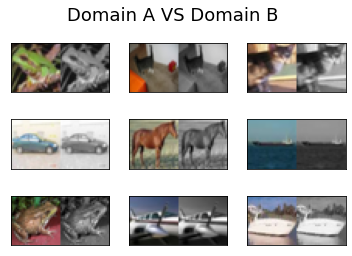

In [23]:
# Load random batch from dataset
random_batch = dataset_loader.get_random_batch(batch_size=9)

# Repeat last dimension for visualization
tmp = np.repeat(random_batch[1], 3, axis=3)

N=3
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Domain A VS Domain B', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((random_batch[0][idx], tmp[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [27]:
from keras.layers import Dropout, concatenate, UpSampling2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Reshape, Flatten, Activation
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Conv2D, Input, Dense, Reshape, Flatten
from keras.optimizers import Adam

def build_generator(im_shape):
  
  img_B = Input(shape=(im_shape[0], im_shape[1], 1))
  
  ## Encoder part
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(img_B)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate=0.5)(conv5)

  ## Now the decoder starts
  up6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(3, 3,  padding = 'same')(conv9)

  model = Model(inputs = img_B, outputs = conv10, name='generator')
  
  return model

In [19]:
def showColoredIms(imB, fake_imA, real_imA):
  
  plt.subplot(131)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('Domain B', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(132)
  plt.imshow(np.clip(fake_imA[0], 0, 1)) 
  plt.title('Fake A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(133)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

def showColored_two_models_Ims(imB, fake_imA_MAE, fake_imA_cGAN, real_imA):
  
  plt.subplot(141)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('BW', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(142)
  plt.imshow(np.clip(fake_imA_MAE[0], 0, 1)) 
  plt.title('MAE', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(143)
  plt.imshow(np.clip(fake_imA_cGAN[0], 0, 1))
  plt.title('cGAN', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(144)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

In [28]:
def build_discriminator(im_shape):
  
  img_A = Input(shape=(im_shape[0], im_shape[1], 3))
  img_B = Input(shape=(im_shape[0], im_shape[1], 1))

  combined_imgs = concatenate([img_A, img_B], axis=-1)
    
  disc_layer = Conv2D(64, kernel_size=(5, 5), padding='same', strides=(2, 2))(combined_imgs)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)
  
  disc_layer = Conv2D(64, kernel_size=(5, 5), padding='same', strides=(2, 2))(disc_layer)
  disc_layer = BatchNormalization(momentum=0.8)(disc_layer)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)

  disc_layer = Conv2D(128, kernel_size=(5, 5), strides=(2, 2))(disc_layer)
  disc_layer = BatchNormalization(momentum=0.8)(disc_layer)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)
  
  disc_layer = Flatten()(disc_layer)
  disc_layer = Dense(1024)(disc_layer)

  prob = Dense(1, name="disc_dense")(disc_layer)

  discriminator = Model(inputs=[img_A, img_B], outputs=[prob], name='discriminator')
  
  return discriminator


In [43]:
def showColoredIms(imB, fake_imA, real_imA):
  
  plt.subplot(131)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('Domain B', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(132)
  plt.imshow(np.clip(fake_imA[0], 0, 1)) 
  plt.title('Fake A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(133)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

def showColored_two_models_Ims(imB, fake_imA_MAE, fake_imA_cGAN, real_imA):
  
  plt.subplot(141)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('BW', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(142)
  plt.imshow(np.clip(fake_imA_MAE[0], 0, 1)) 
  plt.title('MAE', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(143)
  plt.imshow(np.clip(fake_imA_cGAN[0], 0, 1))
  plt.title('cGAN', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(144)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

In [29]:
# Define optimizers for each network.
# Note that if the discriminator is able to differentiate between samples, 
# the generator will be not able to learn. They must learn at the same time.
# Setting the learning rates or learning steps is always tricky.
optimizer_g = Adam(0.0002, 0.5)
optimizer_d = Adam(0.00002, 0.5)

# Input size
im_shape = (32, 32)

# Build and compile the discriminator
discriminator = build_discriminator(im_shape)
discriminator.compile(loss='mse', optimizer=optimizer_d, metrics=['accuracy'])

# Build the generator
generator = build_generator(im_shape)

# Input images and their conditioning images
img_A = Input(shape=(im_shape[0], im_shape[1], 3))
img_B = Input(shape=(im_shape[0], im_shape[1], 1))

# By conditioning on B generate a fake version of A.
# Remember, images in B are the B&W version of images in A
fake_A = generator(img_B)

# For the combined model we will only train the generator, thus, we freeze the
# discriminator model when optimizing G.
# We are backpropagating the discriminator's error
# into the generator in order to create fake images that are unrecognizable by D
discriminator.trainable = False

# Discriminators determines if a conditioned pair has been generated or is real
valid = discriminator([fake_A, img_B])

# Minimize discriminator error (only updating generator's weights) and 
# the L1 loss between real and fake images.
combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer_g)

Instructions for updating:
Colocations handled automatically by placer.


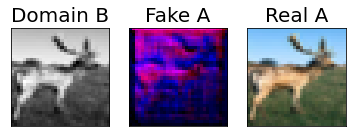

[Epoch 0/1] [Batch 0/390] [D loss: 0.947811, acc:  43%] [G loss: 76.395500] elapsed_time: 0:00:07.958043  remaining_time: 0:51:35.678727
[Epoch 0/1] [Batch 10/390] [D loss: 0.449623, acc:  58%] [G loss: 35.149212] elapsed_time: 0:00:09.956012  remaining_time: 0:05:43.029868
[Epoch 0/1] [Batch 20/390] [D loss: 0.445000, acc:  52%] [G loss: 24.492836] elapsed_time: 0:00:12.025412  remaining_time: 0:03:31.303791
[Epoch 0/1] [Batch 30/390] [D loss: 0.475859, acc:  45%] [G loss: 19.873087] elapsed_time: 0:00:13.946845  remaining_time: 0:02:41.513382
[Epoch 0/1] [Batch 40/390] [D loss: 0.487500, acc:  42%] [G loss: 17.210335] elapsed_time: 0:00:15.840565  remaining_time: 0:02:14.837895


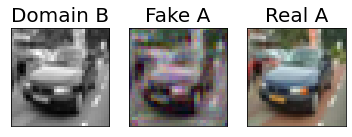

[Epoch 0/1] [Batch 50/390] [D loss: 0.491684, acc:  39%] [G loss: 15.557112] elapsed_time: 0:00:17.727391  remaining_time: 0:01:57.835044
[Epoch 0/1] [Batch 60/390] [D loss: 0.490971, acc:  38%] [G loss: 14.341613] elapsed_time: 0:00:19.742554  remaining_time: 0:01:46.480192
[Epoch 0/1] [Batch 70/390] [D loss: 0.487262, acc:  37%] [G loss: 13.444145] elapsed_time: 0:00:21.813634  remaining_time: 0:01:38.007646
[Epoch 0/1] [Batch 80/390] [D loss: 0.482127, acc:  36%] [G loss: 12.731482] elapsed_time: 0:00:23.851182  remaining_time: 0:01:30.987831
[Epoch 0/1] [Batch 90/390] [D loss: 0.477186, acc:  35%] [G loss: 12.143081] elapsed_time: 0:00:25.774801  remaining_time: 0:01:24.688760


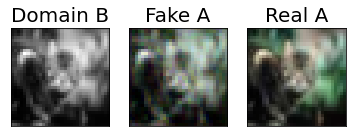

[Epoch 0/1] [Batch 100/390] [D loss: 0.471750, acc:  35%] [G loss: 11.673711] elapsed_time: 0:00:27.676386  remaining_time: 0:01:19.192936
[Epoch 0/1] [Batch 110/390] [D loss: 0.466109, acc:  35%] [G loss: 11.269809] elapsed_time: 0:00:29.667965  remaining_time: 0:01:14.570841
[Epoch 0/1] [Batch 120/390] [D loss: 0.459945, acc:  35%] [G loss: 10.904778] elapsed_time: 0:00:31.562789  remaining_time: 0:01:10.168381
[Epoch 0/1] [Batch 130/390] [D loss: 0.454059, acc:  35%] [G loss: 10.579703] elapsed_time: 0:00:33.449414  remaining_time: 0:01:06.132801
[Epoch 0/1] [Batch 140/390] [D loss: 0.447855, acc:  35%] [G loss: 10.305888] elapsed_time: 0:00:35.428921  remaining_time: 0:01:02.565981


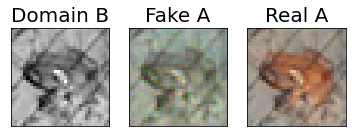

[Epoch 0/1] [Batch 150/390] [D loss: 0.441234, acc:  35%] [G loss: 10.066256] elapsed_time: 0:00:37.411642  remaining_time: 0:00:59.214401
[Epoch 0/1] [Batch 160/390] [D loss: 0.434819, acc:  35%] [G loss: 9.851619] elapsed_time: 0:00:39.389375  remaining_time: 0:00:56.025995
[Epoch 0/1] [Batch 170/390] [D loss: 0.428481, acc:  36%] [G loss: 9.651201] elapsed_time: 0:00:41.268130  remaining_time: 0:00:52.852146
[Epoch 0/1] [Batch 180/390] [D loss: 0.422152, acc:  36%] [G loss: 9.468428] elapsed_time: 0:00:43.157386  remaining_time: 0:00:49.833751
[Epoch 0/1] [Batch 190/390] [D loss: 0.415654, acc:  37%] [G loss: 9.305988] elapsed_time: 0:00:45.020124  remaining_time: 0:00:46.905693


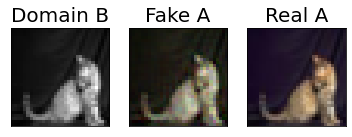

[Epoch 0/1] [Batch 200/390] [D loss: 0.408780, acc:  37%] [G loss: 9.152512] elapsed_time: 0:00:46.948842  remaining_time: 0:00:44.145864
[Epoch 0/1] [Batch 210/390] [D loss: 0.401777, acc:  38%] [G loss: 9.017844] elapsed_time: 0:00:49.092533  remaining_time: 0:00:41.647214
[Epoch 0/1] [Batch 220/390] [D loss: 0.394450, acc:  39%] [G loss: 8.889524] elapsed_time: 0:00:50.961175  remaining_time: 0:00:38.970386
[Epoch 0/1] [Batch 230/390] [D loss: 0.387401, acc:  40%] [G loss: 8.769140] elapsed_time: 0:00:52.831016  remaining_time: 0:00:36.364254
[Epoch 0/1] [Batch 240/390] [D loss: 0.379909, acc:  41%] [G loss: 8.653650] elapsed_time: 0:00:54.683846  remaining_time: 0:00:33.808696


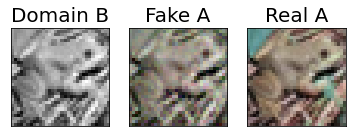

[Epoch 0/1] [Batch 250/390] [D loss: 0.371979, acc:  43%] [G loss: 8.544403] elapsed_time: 0:00:56.532427  remaining_time: 0:00:31.306831
[Epoch 0/1] [Batch 260/390] [D loss: 0.363720, acc:  44%] [G loss: 8.450903] elapsed_time: 0:00:58.499943  remaining_time: 0:00:28.913802
[Epoch 0/1] [Batch 270/390] [D loss: 0.355543, acc:  46%] [G loss: 8.356939] elapsed_time: 0:01:00.582232  remaining_time: 0:00:26.602569
[Epoch 0/1] [Batch 280/390] [D loss: 0.347312, acc:  47%] [G loss: 8.272643] elapsed_time: 0:01:02.454885  remaining_time: 0:00:24.226231
[Epoch 0/1] [Batch 290/390] [D loss: 0.339176, acc:  48%] [G loss: 8.192006] elapsed_time: 0:01:04.317741  remaining_time: 0:00:21.881277


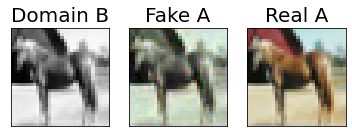

[Epoch 0/1] [Batch 300/390] [D loss: 0.331189, acc:  50%] [G loss: 8.109720] elapsed_time: 0:01:06.162438  remaining_time: 0:00:19.563001
[Epoch 0/1] [Batch 310/390] [D loss: 0.323347, acc:  51%] [G loss: 8.034870] elapsed_time: 0:01:08.252650  remaining_time: 0:00:17.337498
[Epoch 0/1] [Batch 320/390] [D loss: 0.315472, acc:  52%] [G loss: 7.967031] elapsed_time: 0:01:10.478533  remaining_time: 0:00:15.149571
[Epoch 0/1] [Batch 330/390] [D loss: 0.307759, acc:  54%] [G loss: 7.898218] elapsed_time: 0:01:12.974985  remaining_time: 0:00:13.007612
[Epoch 0/1] [Batch 340/390] [D loss: 0.300412, acc:  55%] [G loss: 7.832110] elapsed_time: 0:01:15.076299  remaining_time: 0:00:10.788085


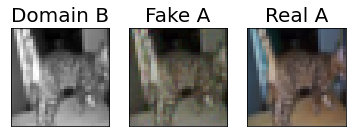

[Epoch 0/1] [Batch 350/390] [D loss: 0.293318, acc:  56%] [G loss: 7.773748] elapsed_time: 0:01:17.265892  remaining_time: 0:00:08.585109
[Epoch 0/1] [Batch 360/390] [D loss: 0.286682, acc:  57%] [G loss: 7.716925] elapsed_time: 0:01:19.503003  remaining_time: 0:00:06.386670
[Epoch 0/1] [Batch 370/390] [D loss: 0.280196, acc:  58%] [G loss: 7.659980] elapsed_time: 0:01:21.540784  remaining_time: 0:00:04.175934
[Epoch 0/1] [Batch 380/390] [D loss: 0.274104, acc:  59%] [G loss: 7.605398] elapsed_time: 0:01:23.759253  remaining_time: 0:00:01.978569


In [31]:
num_epochs = 1
batch_size = 128
n_batches = dataset_loader.get_num_batches(batch_size)

# Adversarial loss ground truths. 
# They are used as labels for the discriminator loss.
valid = np.ones((batch_size,))
fake = np.zeros((batch_size,))
     
for epoch in range(num_epochs):
  
  start_time = datetime.datetime.now()
  
  # Record average losses. Monitorize the loss function. 
  g_avg_loss = []
  d_avg_loss = []
  d_avg_acc = []

  # load_batch() returns a batch generator
  # Before starting the epoch, it shuffles the dataset
  for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size)):
      
    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Condition on B and generate a translated (fake) version of A.
    # It will try to color images from B to be as similiar as possible 
    # to their correspoding pairs from A.
    fake_A = generator.predict(imgs_B)      

    # Train the discriminator (original images = real / generated = Fake)
    d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
    d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_avg_loss.append(d_loss[0])
    d_avg_acc.append(d_loss[1])
    
    # -----------------
    #  Train Generator
    # -----------------

    # Train the generators
    g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
    g_avg_loss.append(g_loss[0])
    
    elapsed_time = datetime.datetime.now() - start_time
    
    # Aproximation of epoch remaining time
    remaining_time = (elapsed_time/(batch_i+1)) * (n_batches-batch_i-1)

    # Plot examples          
    if batch_i%50 == 0:
      showColoredIms(imgs_B, fake_A, imgs_A)      

    # Plot the progress
    if batch_i%10 == 0:          

      print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] elapsed_time: %s  remaining_time: %s" % (epoch, num_epochs,
              batch_i, n_batches, np.mean(d_avg_loss), 100*np.mean(d_avg_acc), np.mean(g_avg_loss), elapsed_time, remaining_time))            
        
  # Saves optimizer and weights
  generator.save('generator.h5') 
  discriminator.save('discriminator.h5')

In [32]:
from google.colab  import files

# Download the weights in your PC
files.download('generator.h5') 
files.download('discriminator.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
# Load weights from a previous session
# Upload weights to Colab by using the File tab

!wget -O weights.zip https://imperialcollegelondon.box.com/shared/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
!unzip -q ./weights.zip
!rm ./weights.zip

generator = keras.models.load_model('./weights/generator.h5')
discriminator = keras.models.load_model('./weights/discriminator.h5')

--2023-03-14 18:31:21--  https://imperialcollegelondon.box.com/shared/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 74.112.186.144
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip [following]
--2023-03-14 18:31:21--  https://imperialcollegelondon.box.com/public/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip [following]
--2023-03-14 18:31:21--  https://imperialcollegelondon.app.box.com/public/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.box.

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2357: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


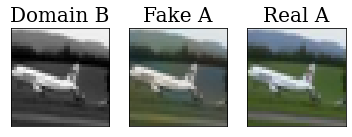

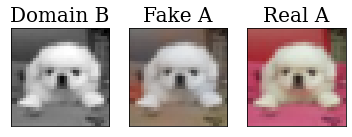

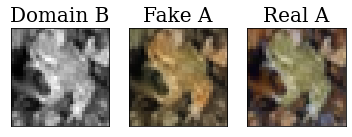

In [35]:
# Load random batch from dataset

for i in range(3):
  [im_A_real, im_B_test] = dataset_loader.get_random_batch(batch_size=1, is_training=False)

  im_A_fake = generator.predict(im_B_test)

  showColoredIms(im_B_test, im_A_fake, im_A_real)

## MAE

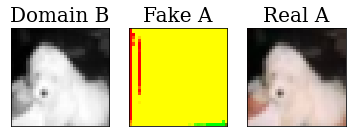

[Epoch 0/1] [Batch 0/390] [G loss: 0.320544] elapsed_time: 0:00:04.983836  remaining_time: 0:32:18.712204
[Epoch 0/1] [Batch 10/390] [G loss: 3.542109] elapsed_time: 0:00:06.790566  remaining_time: 0:03:53.965796
[Epoch 0/1] [Batch 20/390] [G loss: 1.900998] elapsed_time: 0:00:08.371500  remaining_time: 0:02:27.099267
[Epoch 0/1] [Batch 30/390] [G loss: 1.312098] elapsed_time: 0:00:09.962720  remaining_time: 0:01:55.374702
[Epoch 0/1] [Batch 40/390] [G loss: 1.007461] elapsed_time: 0:00:11.553663  remaining_time: 0:01:38.347153


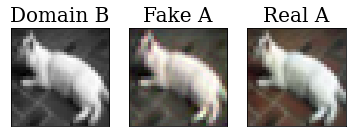

[Epoch 0/1] [Batch 50/390] [G loss: 0.821807] elapsed_time: 0:00:13.156098  remaining_time: 0:01:27.449457
[Epoch 0/1] [Batch 60/390] [G loss: 0.696071] elapsed_time: 0:00:14.844274  remaining_time: 0:01:20.061821
[Epoch 0/1] [Batch 70/390] [G loss: 0.605811] elapsed_time: 0:00:16.470118  remaining_time: 0:01:13.999387
[Epoch 0/1] [Batch 80/390] [G loss: 0.537562] elapsed_time: 0:00:18.144749  remaining_time: 0:01:09.218781
[Epoch 0/1] [Batch 90/390] [G loss: 0.484299] elapsed_time: 0:00:19.773982  remaining_time: 0:01:04.971803


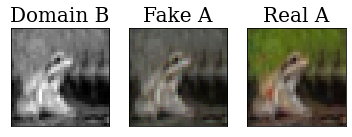

[Epoch 0/1] [Batch 100/390] [G loss: 0.441442] elapsed_time: 0:00:21.370483  remaining_time: 0:01:01.149221
[Epoch 0/1] [Batch 110/390] [G loss: 0.406412] elapsed_time: 0:00:23.067268  remaining_time: 0:00:57.979827
[Epoch 0/1] [Batch 120/390] [G loss: 0.377134] elapsed_time: 0:00:24.656183  remaining_time: 0:00:54.814130
[Epoch 0/1] [Batch 130/390] [G loss: 0.352547] elapsed_time: 0:00:26.254590  remaining_time: 0:00:51.908003
[Epoch 0/1] [Batch 140/390] [G loss: 0.331623] elapsed_time: 0:00:27.840175  remaining_time: 0:00:49.164552


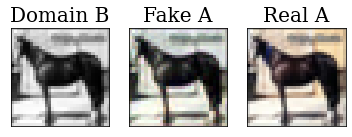

[Epoch 0/1] [Batch 150/390] [G loss: 0.313389] elapsed_time: 0:00:29.451716  remaining_time: 0:00:46.615516
[Epoch 0/1] [Batch 160/390] [G loss: 0.297173] elapsed_time: 0:00:31.249926  remaining_time: 0:00:44.448671
[Epoch 0/1] [Batch 170/390] [G loss: 0.282826] elapsed_time: 0:00:32.876691  remaining_time: 0:00:42.105159
[Epoch 0/1] [Batch 180/390] [G loss: 0.270008] elapsed_time: 0:00:34.464030  remaining_time: 0:00:39.795481
[Epoch 0/1] [Batch 190/390] [G loss: 0.258523] elapsed_time: 0:00:36.050055  remaining_time: 0:00:37.560056


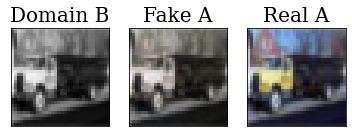

[Epoch 0/1] [Batch 200/390] [G loss: 0.248151] elapsed_time: 0:00:37.633708  remaining_time: 0:00:35.386848
[Epoch 0/1] [Batch 210/390] [G loss: 0.238846] elapsed_time: 0:00:39.313824  remaining_time: 0:00:33.351459
[Epoch 0/1] [Batch 220/390] [G loss: 0.230358] elapsed_time: 0:00:40.894806  remaining_time: 0:00:31.272436
[Epoch 0/1] [Batch 230/390] [G loss: 0.222522] elapsed_time: 0:00:42.479202  remaining_time: 0:00:29.238987
[Epoch 0/1] [Batch 240/390] [G loss: 0.215341] elapsed_time: 0:00:44.123375  remaining_time: 0:00:27.279665


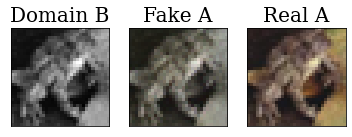

[Epoch 0/1] [Batch 250/390] [G loss: 0.208717] elapsed_time: 0:00:45.751348  remaining_time: 0:00:25.336364
[Epoch 0/1] [Batch 260/390] [G loss: 0.202671] elapsed_time: 0:00:47.420268  remaining_time: 0:00:23.437623
[Epoch 0/1] [Batch 270/390] [G loss: 0.197020] elapsed_time: 0:00:48.982941  remaining_time: 0:00:21.509131
[Epoch 0/1] [Batch 280/390] [G loss: 0.191722] elapsed_time: 0:00:50.562053  remaining_time: 0:00:19.613024
[Epoch 0/1] [Batch 290/390] [G loss: 0.186838] elapsed_time: 0:00:52.119172  remaining_time: 0:00:17.731296


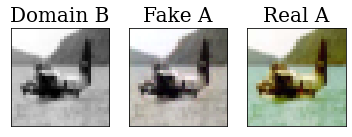

[Epoch 0/1] [Batch 300/390] [G loss: 0.182327] elapsed_time: 0:00:53.679468  remaining_time: 0:00:15.871993
[Epoch 0/1] [Batch 310/390] [G loss: 0.178015] elapsed_time: 0:00:55.360255  remaining_time: 0:00:14.062553
[Epoch 0/1] [Batch 320/390] [G loss: 0.173985] elapsed_time: 0:00:57.001181  remaining_time: 0:00:12.252606
[Epoch 0/1] [Batch 330/390] [G loss: 0.170222] elapsed_time: 0:00:58.651833  remaining_time: 0:00:10.454564
[Epoch 0/1] [Batch 340/390] [G loss: 0.166684] elapsed_time: 0:01:00.223613  remaining_time: 0:00:08.653841


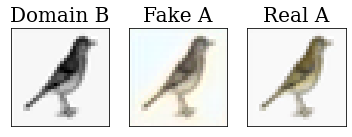

[Epoch 0/1] [Batch 350/390] [G loss: 0.163351] elapsed_time: 0:01:01.784508  remaining_time: 0:00:06.864936
[Epoch 0/1] [Batch 360/390] [G loss: 0.160168] elapsed_time: 0:01:03.462677  remaining_time: 0:00:05.098113
[Epoch 0/1] [Batch 370/390] [G loss: 0.157209] elapsed_time: 0:01:05.026959  remaining_time: 0:00:03.330225
[Epoch 0/1] [Batch 380/390] [G loss: 0.154358] elapsed_time: 0:01:06.589599  remaining_time: 0:00:01.572984


In [36]:
# Input images and their conditioning images
img_A = Input(shape=(im_shape[0], im_shape[1], 3))
img_B = Input(shape=(im_shape[0], im_shape[1], 1))

# Build the generator
generator_mae = build_generator(im_shape)
fake_A = generator_mae(img_B)
generator_mae = Model(inputs=img_B, outputs=fake_A)
generator_mae.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])

num_epochs = 1
batch_size = 128
n_batches = dataset_loader.get_num_batches(batch_size)
     
for epoch in range(num_epochs):
  
  start_time = datetime.datetime.now()
  
  # Record average losses. Monitorize the loss function. 
  g_avg_loss = []

  # load_batch() returns a batch generator
  # Before starting the epoch, it shuffles the dataset
  for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size)):
    
    # -----------------
    #  Train Generator (MAE)
    # -----------------
    g_loss = generator_mae.train_on_batch(imgs_B, imgs_A)
    g_avg_loss.append(g_loss[0])

    fake_A = generator_mae.predict(imgs_B)  

    elapsed_time = datetime.datetime.now() - start_time
    
    # Aproximation of epoch remaining time
    remaining_time = (elapsed_time/(batch_i+1)) * (n_batches-batch_i-1)

    # Plot examples          
    if batch_i%50 == 0:
      showColoredIms(imgs_B, fake_A, imgs_A)      
    
    # Plot the progress
    if batch_i%10 == 0:          

      print ("[Epoch %d/%d] [Batch %d/%d] [G loss: %f] elapsed_time: %s  remaining_time: %s" % (epoch, num_epochs,
              batch_i, n_batches, np.mean(g_avg_loss), elapsed_time, remaining_time))            
        
  # Saves optimizer and weights
  generator_mae.save('generator_mae.h5') 
  

In [37]:
!wget -O weights.zip https://imperialcollegelondon.box.com/shared/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
!unzip -q ./weights.zip
!rm ./weights.zip

!wget -O weights_mae.zip https://imperialcollegelondon.box.com/shared/static/empxfp2v05xp7h8rwsccuiy35c3vddzd.zip
!unzip -q ./weights_mae.zip
!rm ./weights_mae.zip

generator_cGAN = keras.models.load_model('./weights/generator.h5')
generator_mae = keras.models.load_model('mae_generator.h5', compile=False)

generator_cGAN.compile(optimizer='Adam', loss='mean_absolute_error', metrics=['mae'])
generator_mae.compile(optimizer='Adam', loss='mean_absolute_error', metrics=['mae'])

--2023-03-14 18:45:10--  https://imperialcollegelondon.box.com/shared/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 74.112.186.144
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip [following]
--2023-03-14 18:45:10--  https://imperialcollegelondon.box.com/public/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip [following]
--2023-03-14 18:45:10--  https://imperialcollegelondon.app.box.com/public/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.box.

In [38]:
g_mae_avg_mae = []
for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(128, is_training=False)):
    _, mae = generator_mae.evaluate(imgs_B, imgs_A, verbose=0)
    g_mae_avg_mae.append(mae)

print("MAE (Trained MAE): {:.4f}".format(np.mean(g_mae_avg_mae)))

g_cgan_avg_mae = []
for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(128, is_training=False)):
    _, mae = generator_cGAN.evaluate(imgs_B, imgs_A, verbose=0)
    g_cgan_avg_mae.append(mae)

print("MAE (Trained cGAN): {:.4f}".format(np.mean(g_cgan_avg_mae)))

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


MAE (Trained MAE): 0.0449
MAE (Trained cGAN): 0.0458


In [39]:
iterator = iter(dataset_loader.load_batch(1, is_training=False))

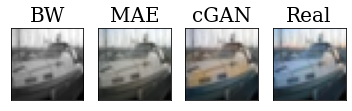

In [44]:
# Load test example
[imgs_A, imgs_B] = next(iterator)

# Generate predictions for both models
fake_A_cGAN = generator_cGAN.predict(imgs_B)
fake_A_MAE = generator_mae.predict(imgs_B)

# Plot all images
showColored_two_models_Ims(imgs_B, fake_A_MAE, fake_A_cGAN, imgs_A)

In [ ]:
y